# Modelo de CLTV

## Importo Dataset de Features de Clientes y su Valoración

El objetivo de este trabajo analítico consiste en desarrollar un Modelo que nos permita predecir mensualmente, con determinado grado de precisión y exactitud, los grupos de clientes de muy baja valoración, mediana, alta y muy alta en función de sus características demográficas, la tenencia de productos, los movimientos e interacción con su banco.
La utilidad del modelo apunta a tener una clasificación mensual actualizada de los grupos de valor mencionados en los que se distribuirá la cartera de clientes en cuestión, debido a que el sistema de valoración de la empresa realiza cálculos de asignación y distribución de ingresos y costos reales con un rezago de algunos meses, y este modelo permitiría que en base a la información mensual disponible del cliente, se pueda predecir mensualmente en qué grupo se encuentra cada cliente a fin de mes. 

In [212]:
#Importo principales librerías a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
import pkgutil
import encodings
import os

def all_encodings():
    modnames = set([modname for importer, modname, ispkg in pkgutil.walk_packages(
        path=[os.path.dirname(encodings.__file__)], prefix='')])
    aliases = set(encodings.aliases.aliases.values())
    return modnames.union(aliases)

text = b'\x96'
for enc in all_encodings():
    try:
        msg = text.decode(enc)
    except Exception:
        continue
    if msg == 'ñ':
        print('Decoding {t} with {enc} is {m}'.format(t=text, enc=enc, m=msg))
pd.options.display.float_format = "{:.2f}".format

Decoding b'\x96' with mac_roman is ñ
Decoding b'\x96' with mac_turkish is ñ
Decoding b'\x96' with mac_croatian is ñ
Decoding b'\x96' with mac_iceland is ñ
Decoding b'\x96' with mac_romanian is ñ
Decoding b'\x96' with mac_arabic is ñ
Decoding b'\x96' with mac_farsi is ñ


/Users/nicolashmartins/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: unicode_internal codec has been deprecated


In [160]:
# Busco directorio actual
print(os.getcwd())

/Users/nicolashmartins/Google Drive/TFI ITBA


In [213]:
dataset= pd.read_csv('GENERACION_DATASET201901v2.csv', encoding='latin1', sep=',')

## Análisis Descriptivo Exploratorio

Comenzamos por analizar un snapshot o foto de la cartera de clientes en un mes determinado de 2018, que contiene un conjunto amplio de variables tales como: Edad, Sexo, Ubicación Geográfica, Nivel de Ingresos informado, Tenencia de Productos Crediticios, Transaccionales, Movimiento de Vuentas, Segmentación Comercial y diversos cálculos de su Valor Real, esto es, el valor calculado por el sistema de Valoración coportativo tomando promedios los últimos 3, 6 y 12 meses.

In [214]:
# Altenativa de muestreo aleaotrio de dataset para agilizar el disovery y modelado en entorno local
dataset = dataset.sample(frac=0.2, random_state=1)

In [215]:
dataset.head(4)

,PERIODO,CODIGO_CLIENTE,CLI_INDICE_CROSS_SELL,CLI_ANTIG_CLIENTE_PROD_VIGENTES,CLI_POSICION_PASIVA,CLI_POSICION_ACTIVA,CLI_SEXO,EDAD,CLI_CATEGORIA,CLI_SITUACION_BCRA,...,FLAG_TD,FLAG_SEGURO,FLAG_PAQUETE_BI,VALOR_PROPIO_PROM_1,VALOR_PROPIO_PROM_3,VALOR_PROPIO_PROM_6,VALOR_PROPIO_PROM_12,VALOR_PROPIO_PROM_1.1,VALOR_PROPIO_PROM_3.1,DIVISION_SUCURSAL
113169,201810,6387694,1,61,0.00,21146.09,F,53,No Categorizado,1. En situaci_n y cumplimiento normal,...,0,0,0,-437.82,-289.90,-184.82,-157.72,-96.88,-494.99,AMBA
180316,201810,8465697,1,37,7614.40,0.00,M,31,No Categorizado,Cliente sin deuda,...,1,0,0,35.15,163.12,93.11,38.26,-9.00,20.55,NEA
75942,201810,5034697,1,128,13975.36,0.00,M,74,No Categorizado,Cliente sin deuda,...,1,0,0,398.59,298.74,212.80,148.02,623.65,437.89,SANTA FE
117522,201810,6616295,2,82,5699.06,0.00,M,74,No Categorizado,Cliente sin deuda,...,1,1,0,51.59,-1.51,-25.98,-31.35,199.40,244.59,PROVINCIA BS. AS.


In [164]:
# Descripción de columnas del dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47750 entries, 113169 to 133877
Data columns (total 81 columns):
PERIODO                            47750 non-null int64
CODIGO_CLIENTE                     47750 non-null int64
CLI_INDICE_CROSS_SELL              47750 non-null int64
CLI_ANTIG_CLIENTE_PROD_VIGENTES    47750 non-null int64
CLI_POSICION_PASIVA                47750 non-null float64
CLI_POSICION_ACTIVA                47750 non-null float64
CLI_SEXO                           47750 non-null object
EDAD                               47750 non-null int64
CLI_CATEGORIA                      47750 non-null object
CLI_SITUACION_BCRA                 47750 non-null object
CLI_SUCURSAL_SOURCE_RADICACION     47750 non-null int64
CLI_CODIGO_IVA                     47750 non-null object
CLI_SEGMENTO                       47750 non-null object
CLI_SUB_SEGMENTO                   47750 non-null object
CLI_SEGMENTO_COMERCIAL             47750 non-null object
CLI_SUB_SEGMENTO_COMERCIAL        

In [44]:
# Descripción de tipos de datos del dataset
dataset.dtypes

PERIODO                              int64
CODIGO_CLIENTE                       int64
CLI_INDICE_CROSS_SELL                int64
CLI_ANTIG_CLIENTE_PROD_VIGENTES      int64
CLI_POSICION_PASIVA                float64
CLI_POSICION_ACTIVA                float64
CLI_SEXO                            object
EDAD                                 int64
CLI_CATEGORIA                       object
CLI_SITUACION_BCRA                  object
CLI_SUCURSAL_SOURCE_RADICACION       int64
CLI_CODIGO_IVA                      object
CLI_SEGMENTO                        object
CLI_SUB_SEGMENTO                    object
CLI_SEGMENTO_COMERCIAL              object
CLI_SUB_SEGMENTO_COMERCIAL          object
CLI_SCORE_DATOS_ADICIONALES        float64
CLI_CANTIDAD_EMPLEADORES             int64
FLAG_CUIT_EMPLEADOR                  int64
CLI_INGRESO_CONSIDERADO             object
CLI_INGRESO                        float64
ACRED_CUPONES_ULT_3                  int64
ANTERIOR_CC_VIGENTE                float64
FLAG_TIENE_

In [165]:
# Analizo si hay valores nulos en dataset
dataset.isnull().sum()

PERIODO                                0
CODIGO_CLIENTE                         0
CLI_INDICE_CROSS_SELL                  0
CLI_ANTIG_CLIENTE_PROD_VIGENTES        0
CLI_POSICION_PASIVA                    0
CLI_POSICION_ACTIVA                    0
CLI_SEXO                               0
EDAD                                   0
CLI_CATEGORIA                          0
CLI_SITUACION_BCRA                     0
CLI_SUCURSAL_SOURCE_RADICACION         0
CLI_CODIGO_IVA                         0
CLI_SEGMENTO                           0
CLI_SUB_SEGMENTO                       0
CLI_SEGMENTO_COMERCIAL                 0
CLI_SUB_SEGMENTO_COMERCIAL             0
CLI_SCORE_DATOS_ADICIONALES            0
CLI_CANTIDAD_EMPLEADORES               0
FLAG_CUIT_EMPLEADOR                    0
CLI_INGRESO_CONSIDERADO                0
CLI_INGRESO                         4570
ACRED_CUPONES_ULT_3                    0
ANTERIOR_CC_VIGENTE                28795
FLAG_TIENE_ANTERIOR_CC_VIG         28795
ULTIMA_CC_VIGENT

In [216]:
# Elimino registros sin Datos de Ingreso ya que son una variable relevante y convertirlos a 0 es incorrecto
dataset.dropna(subset = ['CLI_INGRESO'],inplace=True)

In [217]:
dataset['CLI_INGRESO'].isnull().sum()

0

In [218]:
#Relleno de 0 el resto de los valores vacíos ya que por su contenido no afectan el análisis
dataset=dataset.fillna(0)

In [219]:
# Analizo si hay datos duplicados
len(dataset['CODIGO_CLIENTE'].unique())

43180

In [220]:
len(dataset) - len(dataset['CODIGO_CLIENTE'].unique())

0

In [51]:
# Calculo las medidas de estadística descriptiva de las variables del dataset: DATOS BÁSICOS
dataset[['CLI_INDICE_CROSS_SELL' , 'CLI_ANTIG_CLIENTE_PROD_VIGENTES', 'CLI_POSICION_PASIVA', 'CLI_POSICION_ACTIVA', 'EDAD','CLI_CANTIDAD_EMPLEADORES', 'CLI_INGRESO', 'ACRED_CUPONES_ULT_3']].describe()

,CLI_INDICE_CROSS_SELL,CLI_ANTIG_CLIENTE_PROD_VIGENTES,CLI_POSICION_PASIVA,CLI_POSICION_ACTIVA,EDAD,CLI_CANTIDAD_EMPLEADORES,CLI_INGRESO,ACRED_CUPONES_ULT_3
count,43180.00,43180.00,43180.00,43180.00,43180.00,43180.00,43180.00,43180.00
mean,2.18,84.99,35839.61,28546.99,48.66,0.54,19253.32,0.01
std,1.34,69.71,404244.95,88087.28,17.57,0.56,19725.92,0.10
min,1.00,0.00,0.00,-31405.87,4.00,0.00,0.00,0.00
25%,1.00,29.00,0.82,0.00,35.00,0.00,7634.50,0.00
50%,2.00,67.00,43.42,0.00,46.00,1.00,14588.50,0.00
75%,3.00,128.00,3094.73,25236.08,61.00,1.00,24664.75,0.00
max,9.00,585.00,65154060.00,6607512.37,108.00,6.00,1422600.00,1.00


In [52]:
# Calculo las medidas de estadística descriptiva de las variables del dataset: MOVIMIENTOS EN CUENTA
dataset[['DV_PROM_SALDO', 'DV_CA_ACRED', 'DV_CA_EXTRAC', 'DV_CA_MONTO_TRANS', 'PF_CANT', 'PF_SALDO', 'FLAG_COMPRA_TD']].describe()

,DV_PROM_SALDO,DV_CA_ACRED,DV_CA_EXTRAC,DV_CA_MONTO_TRANS,PF_CANT,PF_SALDO,FLAG_COMPRA_TD
count,43180.00,43180.00,43180.00,43180.00,43180.00,43180.00,43180.00
mean,12220.16,0.73,2.74,3492.41,0.10,25488.30,0.41
std,127852.75,1.36,4.21,72028.63,0.52,385063.60,0.49
min,-96774.19,0.00,0.00,0.00,0.00,0.00,0.00
25%,10.04,0.00,0.00,0.00,0.00,0.00,0.00
50%,512.59,0.00,1.00,0.00,0.00,0.00,0.00
75%,3217.88,1.00,4.00,0.00,0.00,0.00,1.00
max,19014888.56,25.00,117.00,11314558.20,46.00,65154060.00,1.00


In [53]:
# Calculo las medidas de estadística descriptiva de las variables del dataset: DEUDA
dataset[['CLI_DIAS_MORA', 'CLI_SITUACION_BCRA','CLI_SALDO_DEUDA', 'CLI_DIAS_SOBREGIRO', 'CLI_DIAS_ATRASO_BCRA', 'PR_HIPOTECARIOS', 'PR_PERSONALES', 'PR_MESES_CON_PRESTAMOS']].describe()

,CLI_DIAS_MORA,CLI_SALDO_DEUDA,CLI_DIAS_SOBREGIRO,CLI_DIAS_ATRASO_BCRA,PR_HIPOTECARIOS,PR_PERSONALES,PR_MESES_CON_PRESTAMOS
count,43180.00,43180.00,43180.00,43180.00,43180.00,43180.00,43180.00
mean,8.34,28814.42,37.93,37.93,0.00,0.36,14.47
std,49.44,88238.27,358.33,358.33,0.04,0.81,32.17
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.00,25965.53,0.00,0.00,0.00,0.00,0.00
max,361.00,6607512.37,9017.00,9017.00,1.00,12.00,120.00


In [54]:
# Calculo las medidas de estadística descriptiva de las variables del dataset: TENENCIA PRODUCTOS
dataset[['FLAG_CA', 'FLAG_CA_USD', 'FLAG_CC', 'FLAG_TD', 'FLAG_SEGURO', 'FLAG_PAQUETE_BI']].describe()

,FLAG_CA,FLAG_CA_USD,FLAG_CC,FLAG_TD,FLAG_SEGURO,FLAG_PAQUETE_BI
count,43180.00,43180.00,43180.00,43180.00,43180.00,43180.00
mean,0.90,0.11,0.29,0.81,0.36,0.31
std,0.31,0.31,0.46,0.39,0.48,0.46
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,1.00,0.00,0.00,1.00,0.00,0.00
50%,1.00,0.00,0.00,1.00,0.00,0.00
75%,1.00,0.00,1.00,1.00,1.00,1.00
max,1.00,1.00,1.00,1.00,1.00,1.00


In [55]:
# Realizo análisis descriptivo de Valores Promedios de Features Seleccionados de Clientes agrupados por Zona Geográfica
dataset.groupby("DIVISION_SUCURSAL")['CLI_INDICE_CROSS_SELL', 'CLI_ANTIG_CLIENTE_PROD_VIGENTES','EDAD','CLI_POSICION_PASIVA', 'CLI_POSICION_ACTIVA', 'VALOR_PROPIO_PROM_12'].mean()

,CLI_INDICE_CROSS_SELL,CLI_ANTIG_CLIENTE_PROD_VIGENTES,EDAD,CLI_POSICION_PASIVA,CLI_POSICION_ACTIVA,VALOR_PROPIO_PROM_12
DIVISION_SUCURSAL,,,,,,
A DETERMINAR,4.33,209.67,56.67,8147238.68,203508.08,20569.87
AMBA,2.02,83.47,52.31,33990.56,26877.02,217.89
CASA MATRIZ,1.30,76.00,51.50,588.51,7688.18,-354.01
CORDOBA,2.08,73.62,48.95,54940.17,20036.18,352.63
JUJUY,2.30,103.84,48.66,25405.43,30262.57,316.45
NEA,2.38,92.64,46.56,17037.40,31433.08,239.00
PROVINCIA BS. AS.,2.11,75.74,50.96,39514.42,25220.88,231.57
SALTA,2.37,93.26,46.57,25650.37,39253.30,326.51
SANTA FE,2.14,81.80,49.44,39371.22,23908.25,259.48


In [56]:
# Realizo análisis descriptivo de Valores Mínimos de Features Seleccionados de Clientes agrupados por Segmento Comercial
dataset.groupby("CLI_SEGMENTO_COMERCIAL")['CLI_INDICE_CROSS_SELL', 'CLI_ANTIG_CLIENTE_PROD_VIGENTES','EDAD','CLI_POSICION_PASIVA', 'CLI_POSICION_ACTIVA', 'VALOR_PROPIO_PROM_12'].mean()

,CLI_INDICE_CROSS_SELL,CLI_ANTIG_CLIENTE_PROD_VIGENTES,EDAD,CLI_POSICION_PASIVA,CLI_POSICION_ACTIVA,VALOR_PROPIO_PROM_12
CLI_SEGMENTO_COMERCIAL,,,,,,
JUBILADOS,2.70,100.98,67.55,48179.05,25531.25,438.96
MERCADO ABIERTO,1.54,69.69,44.86,26597.75,13854.85,85.84
OTROS SEGMENTOS ESPECIALES,1.21,58.51,33.25,989.58,395.12,-12.00
PLAN SUELDO PRIVADO,2.69,78.22,41.10,37112.32,44357.43,360.55
PLAN SUELDO PUBLICO,3.40,132.85,45.27,30876.74,87855.22,636.41
PROFESIONALES Y NEGOCIOS,2.04,90.40,51.01,76960.06,21787.16,442.83


In [221]:
# Describo la distribución de la Variable a Explicar (Valoración) para decidir el corte de outliers
dataset['VALOR_PROPIO_PROM_12'].describe()

count    43180.00
mean       284.54
std       1277.92
min     -46825.16
25%        -22.83
50%         15.18
75%        300.08
max      57599.34
Name: VALOR_PROPIO_PROM_12, dtype: float64

(-150, 2000)

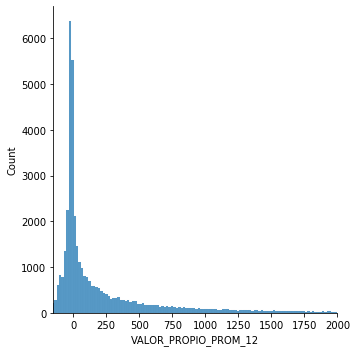

In [58]:
#Grafico un histograma de la Valoración Promedio Mensual de los últimos 12 meses acortando rangos de valor
sns.displot(dataset.VALOR_PROPIO_PROM_12)
plt.xlim(-150, 2000)

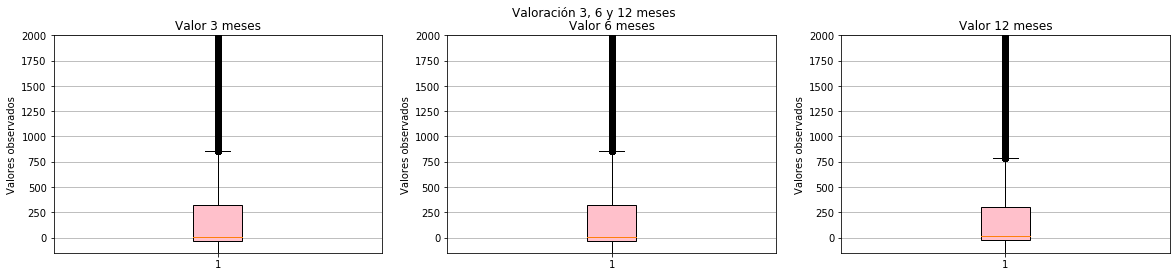

In [59]:
# Dada la alta dispersión, grafico un boxplot de la Valoración Promedio Mensual de los últimos 3,6 y 12 meses del cliente para buscar outliers
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))
fig.suptitle('Valoración 3, 6 y 12 meses')
bplot1 = ax1.boxplot(x=dataset['VALOR_PROPIO_PROM_3'], vert=True, patch_artist=True)
ax1.set_title('Valor 3 meses')
bplot2 = ax2.boxplot(x=dataset['VALOR_PROPIO_PROM_6'], vert=True, patch_artist=True)
ax2.set_title('Valor 6 meses')
bplot3= ax3.boxplot(x=dataset['VALOR_PROPIO_PROM_12'], vert=True, patch_artist=True)
ax3.set_title('Valor 12 meses')
for ax in [ax1, ax2, ax3]:
    ax.yaxis.grid(True)
    ax.set_ylabel('Valores observados')
    ax.set_ylim(-150, 2000)
    plt.ylim(-150, 2000)
    colors = ['pink', 'lightblue', 'lightgreen']
for bplot in (bplot1, bplot2, bplot3):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

(-150, 2000)

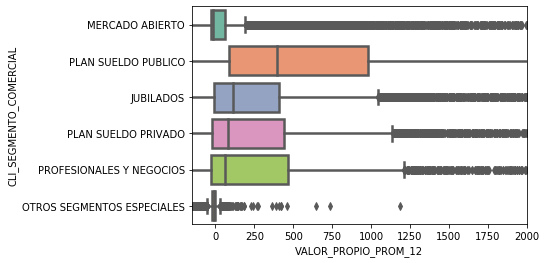

In [60]:
# Grafico el boxplot por Segmento del Cliente
sns.boxplot(y='CLI_SEGMENTO_COMERCIAL', x='VALOR_PROPIO_PROM_12',
                 data=dataset, palette='Set2', linewidth=2.5)
plt.xlim(-150, 2000)

In [222]:
dataset['VALOR_PROPIO_PROM_12'].quantile(0.95)

1635.1169999999956

In [223]:
dataset['VALOR_PROPIO_PROM_12'].quantile(0.05)

-134.5

In [224]:
# Actualizo el dataset quedandome con el 95% de los valores de Valoración a ambos extremos de la distribución
dataset = dataset[np.abs(dataset['VALOR_PROPIO_PROM_12'])<np.abs(dataset['VALOR_PROPIO_PROM_12'].quantile(0.95))]

In [225]:
dataset = dataset[dataset['VALOR_PROPIO_PROM_12']>dataset['VALOR_PROPIO_PROM_12'].quantile(0.05)]

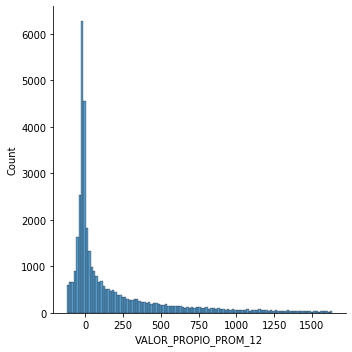

In [65]:
# Grafico nuevamente un histograma con el dataset excluido de outliers
sns.displot(dataset.VALOR_PROPIO_PROM_12)

In [226]:
dataset['VALOR_PROPIO_PROM_12'].describe()

count   38619.00
mean      182.49
std       345.85
min      -122.60
25%       -20.10
50%        16.32
75%       247.62
max      1635.07
Name: VALOR_PROPIO_PROM_12, dtype: float64

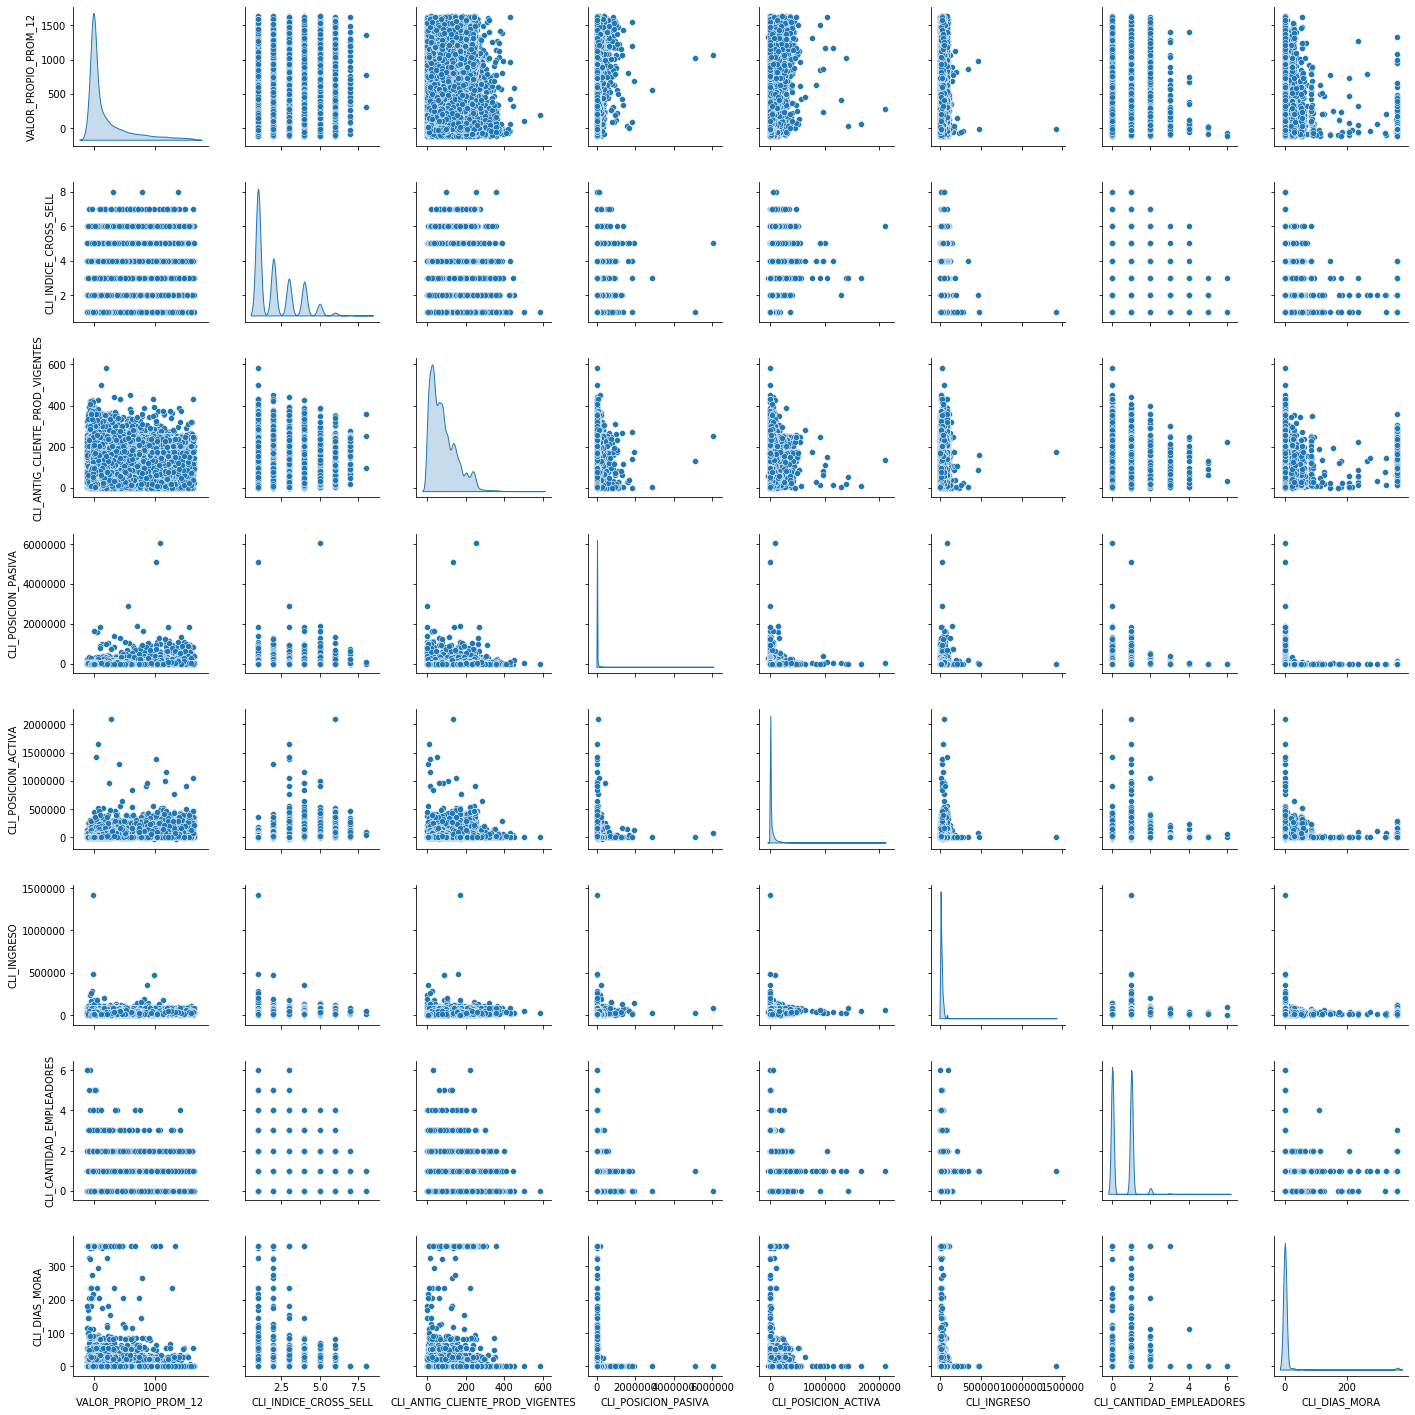

In [67]:
# Grafico la correlación de a pares entre principales variables del dataset
sns.pairplot(dataset, vars=["VALOR_PROPIO_PROM_12", "CLI_INDICE_CROSS_SELL", "CLI_ANTIG_CLIENTE_PROD_VIGENTES", "CLI_POSICION_PASIVA","CLI_POSICION_ACTIVA","CLI_INGRESO","CLI_CANTIDAD_EMPLEADORES", 'CLI_DIAS_MORA'], diag_kind="kde")

In [68]:
# Reflejo el coeficiente de correlación entre las mismas, dado que visualmente es difícil encontrar correlaciones muy claras
dataset[["VALOR_PROPIO_PROM_12","CLI_INDICE_CROSS_SELL", "CLI_ANTIG_CLIENTE_PROD_VIGENTES", "CLI_POSICION_PASIVA","CLI_POSICION_ACTIVA","CLI_INGRESO","CLI_CANTIDAD_EMPLEADORES", 'CLI_DIAS_MORA']].corr()

,VALOR_PROPIO_PROM_12,CLI_INDICE_CROSS_SELL,CLI_ANTIG_CLIENTE_PROD_VIGENTES,CLI_POSICION_PASIVA,CLI_POSICION_ACTIVA,CLI_INGRESO,CLI_CANTIDAD_EMPLEADORES,CLI_DIAS_MORA
VALOR_PROPIO_PROM_12,1.00,0.50,0.28,0.29,0.50,0.22,0.11,-0.06
CLI_INDICE_CROSS_SELL,0.50,1.00,0.32,0.10,0.53,0.16,0.12,-0.02
CLI_ANTIG_CLIENTE_PROD_VIGENTES,0.28,0.32,1.00,0.05,0.22,0.21,0.04,0.06
CLI_POSICION_PASIVA,0.29,0.10,0.05,1.00,-0.00,0.10,-0.00,-0.02
CLI_POSICION_ACTIVA,0.50,0.53,0.22,-0.00,1.00,0.21,0.16,0.01
CLI_INGRESO,0.22,0.16,0.21,0.10,0.21,1.00,0.25,0.01
CLI_CANTIDAD_EMPLEADORES,0.11,0.12,0.04,-0.00,0.16,0.25,1.00,0.05
CLI_DIAS_MORA,-0.06,-0.02,0.06,-0.02,0.01,0.01,0.05,1.00


In [227]:
# Como muchas variables son categóricas o nominales, genero dummies para cada una de ellas.
dataset = pd.get_dummies(dataset, columns=['CLI_SEXO','CLI_CATEGORIA','CLI_SITUACION_BCRA','CLI_CODIGO_IVA','CLI_SEGMENTO_COMERCIAL','CLI_SUB_SEGMENTO_COMERCIAL','CLI_INGRESO_CONSIDERADO','DIVISION_SUCURSAL'])

In [228]:
dataset.head()

,PERIODO,CODIGO_CLIENTE,CLI_INDICE_CROSS_SELL,CLI_ANTIG_CLIENTE_PROD_VIGENTES,CLI_POSICION_PASIVA,CLI_POSICION_ACTIVA,EDAD,CLI_SUCURSAL_SOURCE_RADICACION,CLI_SEGMENTO,CLI_SUB_SEGMENTO,...,DIVISION_SUCURSAL_AMBA,DIVISION_SUCURSAL_CASA MATRIZ,DIVISION_SUCURSAL_CORDOBA,DIVISION_SUCURSAL_JUJUY,DIVISION_SUCURSAL_NEA,DIVISION_SUCURSAL_PROVINCIA BS. AS.,DIVISION_SUCURSAL_SALTA,DIVISION_SUCURSAL_SANTA FE,DIVISION_SUCURSAL_SUROESTE,DIVISION_SUCURSAL_TUCUMAN
180316,201810,8465697,1,37,7614.40,0.00,31,1,Mercado Abierto,Estudiantes,...,0,0,0,0,1,0,0,0,0,0
75942,201810,5034697,1,128,13975.36,0.00,74,785,Jubilados/Pensionados,Jubilados/Pensionados Anses,...,0,0,0,0,0,0,0,1,0,0
117522,201810,6616295,2,82,5699.06,0.00,74,779,Jubilados/Pensionados,Jubilados/Pensionados Anses,...,0,0,0,0,0,1,0,0,0,0
235697,201810,9584492,2,2,242.14,0.00,58,140,Plan Sueldo,Empresas Privadas B,...,0,0,0,0,0,0,0,0,0,1
140545,201810,7338496,1,22,8.12,0.00,27,204,Plan Sueldo,Empresas Privadas C,...,0,0,0,1,0,0,0,0,0,0


In [229]:
# Elimino dos variables que desactualizadas del dataset original (segmento y subsegmento, ya que me quedo con segmento y subsegmento comercial)
dataset = dataset.drop(['CLI_SEGMENTO','CLI_SUB_SEGMENTO'], axis=1)

In [230]:
dataset.head()

,PERIODO,CODIGO_CLIENTE,CLI_INDICE_CROSS_SELL,CLI_ANTIG_CLIENTE_PROD_VIGENTES,CLI_POSICION_PASIVA,CLI_POSICION_ACTIVA,EDAD,CLI_SUCURSAL_SOURCE_RADICACION,CLI_SCORE_DATOS_ADICIONALES,CLI_CANTIDAD_EMPLEADORES,...,DIVISION_SUCURSAL_AMBA,DIVISION_SUCURSAL_CASA MATRIZ,DIVISION_SUCURSAL_CORDOBA,DIVISION_SUCURSAL_JUJUY,DIVISION_SUCURSAL_NEA,DIVISION_SUCURSAL_PROVINCIA BS. AS.,DIVISION_SUCURSAL_SALTA,DIVISION_SUCURSAL_SANTA FE,DIVISION_SUCURSAL_SUROESTE,DIVISION_SUCURSAL_TUCUMAN
180316,201810,8465697,1,37,7614.40,0.00,31,1,0.00,0,...,0,0,0,0,1,0,0,0,0,0
75942,201810,5034697,1,128,13975.36,0.00,74,785,0.00,0,...,0,0,0,0,0,0,0,1,0,0
117522,201810,6616295,2,82,5699.06,0.00,74,779,0.00,0,...,0,0,0,0,0,1,0,0,0,0
235697,201810,9584492,2,2,242.14,0.00,58,140,24274.58,1,...,0,0,0,0,0,0,0,0,0,1
140545,201810,7338496,1,22,8.12,0.00,27,204,0.00,0,...,0,0,0,1,0,0,0,0,0,0


In [232]:
# Genero un sub dataset para evaluar la correlación entre todas las variables con la Valoración Promedio Mensual de 12 meses, excluendo las otras medidas de Valoración que no se utilizarán
datasetsub = dataset.drop(['PERIODO','CODIGO_CLIENTE','VALOR_PROPIO_PROM_1','VALOR_PROPIO_PROM_3','VALOR_PROPIO_PROM_6','VALOR_PROPIO_PROM_1.1',
'VALOR_PROPIO_PROM_3.1'],axis=1)

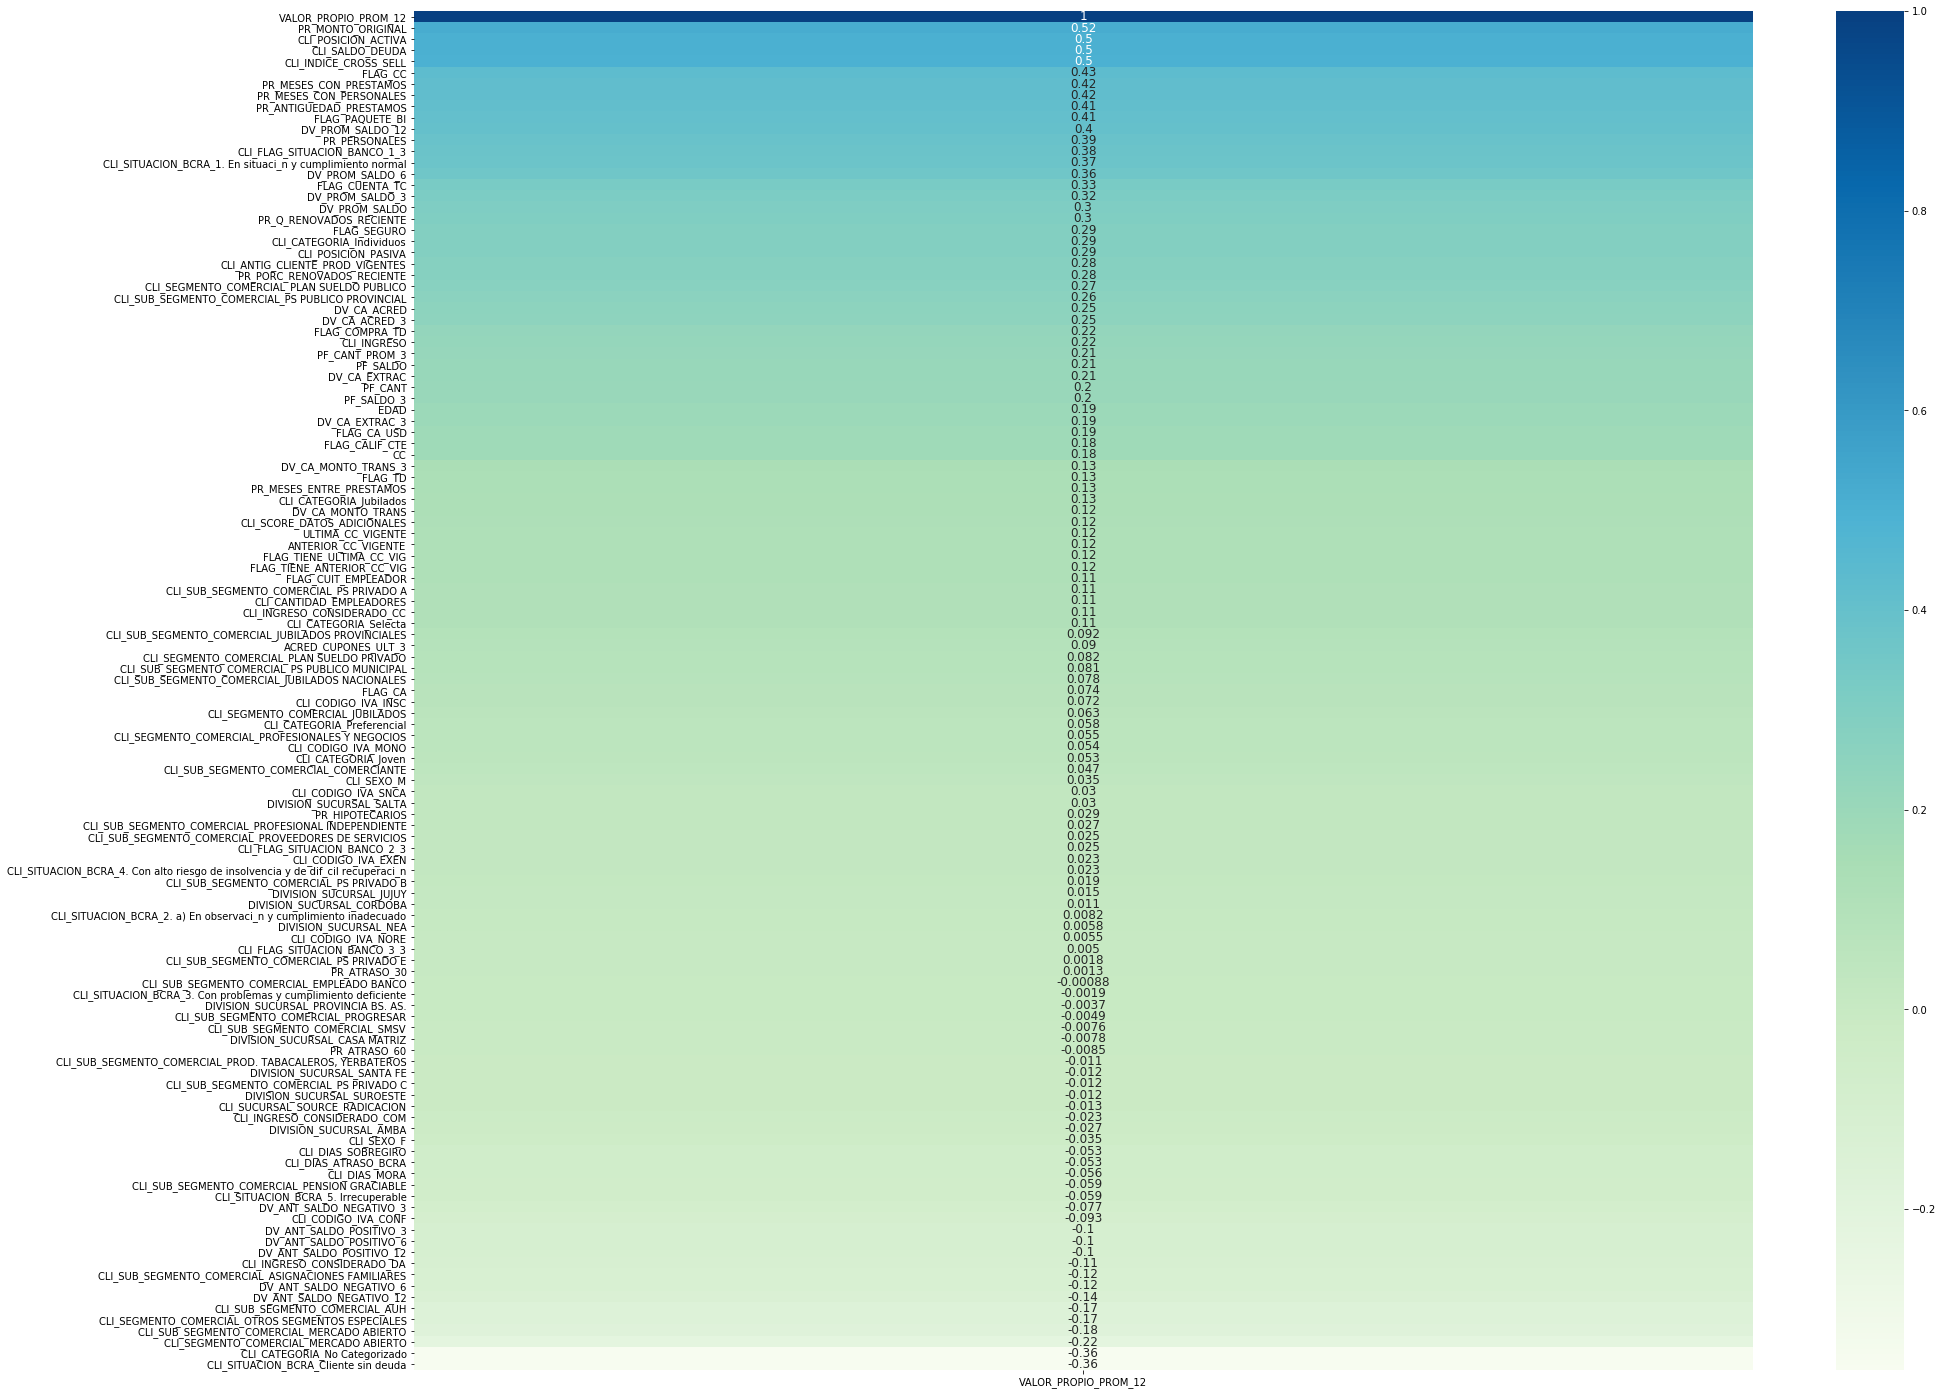

In [233]:
# Grafico un cuadro para evaluar la correlación de todas las variables respecto de Valoración Promedio Mensual de 12 meses
df_corr_valoracion = datasetsub.corr()['VALOR_PROPIO_PROM_12'][:-1].sort_values(ascending=False)
#set fig size
fig, ax = plt.subplots(figsize=(30,25))
#plot matrix
sns.heatmap(df_corr_valoracion.to_frame(),annot=True, annot_kws={'size':12},cmap="GnBu")
plt.show();

## Desarrollo de Agrupamiento de Clientes por Similitud

Luego de haber realizado un análisis de control y limpieza, exploratorio y descriptivo del dataset, y habiendo encontrado correlaciones relevantes entre la Valoración Promedio Mensual de los últimos 12 meses y un grupo importante de variables del cliente, avanzamos en la creación de grupos de clientes similares mediante la técnica de clustering. Comenzamos por agrupar los clientes que son similares en términos de Valoración (que serán las clases a predecir), y luego hacemos iteraciones similares sobre las variables más correlacionadas con la valoración.

In [235]:
# Creo una función para ordenar los cluster numéricos
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [236]:
# Entreno cluster de Valoración Promedio 12 meses
from sklearn.cluster import KMeans
km = KMeans(n_clusters=5)
y=dataset['VALOR_PROPIO_PROM_12']
y=y.values.reshape(-1,1)
km.fit(y)


KMeans(n_clusters=5)

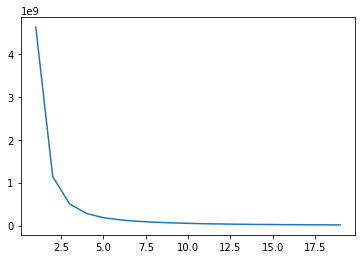

In [185]:
# Chequeo con la técnica del codo la cantidad óptima de clusters
n = range(1,20)
KMScore = []
for i in n:
    
    km = KMeans(n_clusters=i)
    km.fit(y)
    KMScore.append(km.inertia_)
import matplotlib.pyplot as plt
plt.plot(n,KMScore);

In [237]:
# Creo el cluster y lo agrego al dataset
km = KMeans(n_clusters=4)
km.fit(y)
dataset['VALOR12Cluster'] = km.predict(y)

In [238]:
# Creo un nuevo dataset para analizar cómo agrupó los valores el cluster
dataset_cluster = dataset.copy()
dataset_cluster = order_cluster('VALOR12Cluster', 'VALOR_PROPIO_PROM_12',dataset_cluster ,True)
dataset_cluster.groupby('VALOR12Cluster')['VALOR_PROPIO_PROM_12'].describe()

,count,mean,std,min,25%,50%,75%,max
VALOR12Cluster,,,,,,,,
0,26124.00,-2.82,53.89,-122.60,-29.48,-12.47,19.36,146.70
1,6953.00,294.95,103.19,146.74,203.16,277.78,378.64,507.53
2,3536.00,717.59,136.91,507.66,597.62,705.87,829.90,991.35
3,2006.00,1262.67,179.85,991.64,1111.42,1233.81,1404.19,1635.07


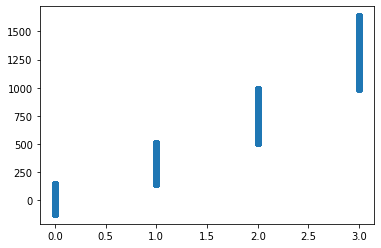

In [239]:
# Evaluo gráficamente la distribución de valores del Cluster 
plt.plot(dataset_cluster['VALOR12Cluster'], dataset_cluster['VALOR_PROPIO_PROM_12'],'o')

In [240]:
# Entreno cluster de Posición Pasiva
from sklearn.cluster import KMeans
km = KMeans(n_clusters=4)
a=dataset['DV_PROM_SALDO_12']
a=a.values.reshape(-1,1)
km.fit(a)

KMeans(n_clusters=4)

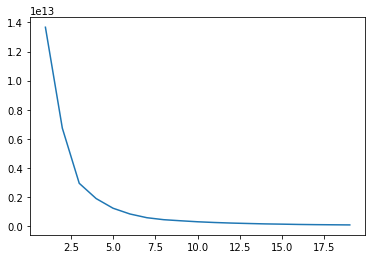

In [190]:
# Chequeo con la técnica del codo la cantidad óptima de clusters
n = range(1,20)
KMScore = []
for i in n:
    
    km = KMeans(n_clusters=i)
    km.fit(a)
    KMScore.append(km.inertia_)
import matplotlib.pyplot as plt
plt.plot(n,KMScore);

In [241]:
# Creo el cluster y lo agrego al dataset
km = KMeans(n_clusters=3)
km.fit(a)
dataset['SALDOVISTACluster'] = km.predict(a)
dataset = order_cluster('SALDOVISTACluster', 'DV_PROM_SALDO_12',dataset,True)

In [242]:
# Creo un nuevo dataset para analizar cómo agrupó los valores el cluster
dataset_cluster = dataset.copy()
dataset_cluster = order_cluster('SALDOVISTACluster', 'DV_PROM_SALDO_12',dataset_cluster ,True)
dataset_cluster.groupby('SALDOVISTACluster')['DV_PROM_SALDO_12'].describe()

,count,mean,std,min,25%,50%,75%,max
SALDOVISTACluster,,,,,,,,
0,36439.00,2567.32,4541.18,-20655.58,66.50,643.59,2647.03,25019.83
1,2097.00,47587.00,23482.42,25034.53,30736.77,40342.84,56505.07,167426.57
2,83.00,289501.87,112521.93,168547.92,204929.58,264025.27,324267.79,696124.48


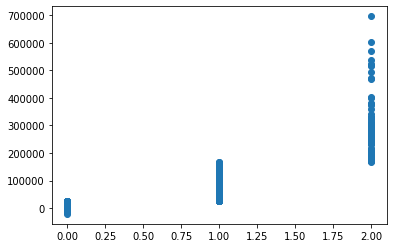

In [243]:
# Evaluo gráficamente la distribución de valores del Cluster 
plt.plot(dataset_cluster['SALDOVISTACluster'], dataset_cluster['DV_PROM_SALDO_12'],'o')

In [244]:
# Entreno cluster de Cross Sell
from sklearn.cluster import KMeans
km = KMeans(n_clusters=5)
b=dataset['CLI_INDICE_CROSS_SELL']
b=b.values.reshape(-1,1)
km.fit(b)

KMeans(n_clusters=5)

/Users/nicolashmartins/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  import sys


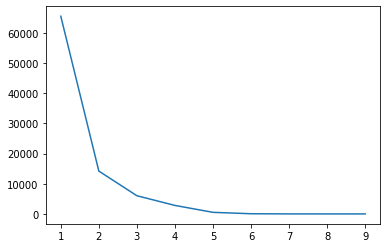

In [195]:
# Chequeo con la técnica del codo la cantidad óptima de clusters
n = range(1,10)
KMScore = []
for i in n:
    
    km = KMeans(n_clusters=i)
    km.fit(b)
    KMScore.append(km.inertia_)
import matplotlib.pyplot as plt
plt.plot(n,KMScore);

In [245]:
# Creo el cluster y lo agrego al dataset
km = KMeans(n_clusters=3)
km.fit(b)
dataset['CROSSELLCluster'] = km.predict(b)
dataset = order_cluster('CROSSELLCluster', 'CLI_INDICE_CROSS_SELL',dataset,True)

In [246]:
# Creo un nuevo dataset para analizar cómo agrupó los valores el cluster
dataset_cluster = dataset.copy()
dataset_cluster = order_cluster('CROSSELLCluster', 'CLI_INDICE_CROSS_SELL',dataset_cluster ,True)
#see details of the clusters
dataset_cluster.groupby('CROSSELLCluster')['CLI_INDICE_CROSS_SELL'].describe()

,count,mean,std,min,25%,50%,75%,max
CROSSELLCluster,,,,,,,,
0,18155.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00
1,13470.00,2.39,0.49,2.00,2.00,2.00,3.00,3.00
2,6994.00,4.38,0.63,4.00,4.00,4.00,5.00,8.00


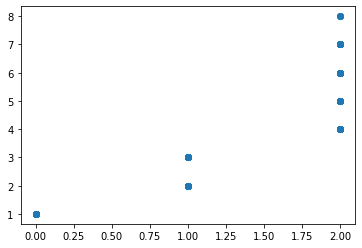

In [198]:
# Evaluo gráficamente la distribución de valores del Cluster 
plt.plot(dataset_cluster['CROSSELLCluster'], dataset_cluster['CLI_INDICE_CROSS_SELL'],'o')

In [247]:
# Entreno cluster de Préstamo
from sklearn.cluster import KMeans
km = KMeans(n_clusters=5)
d=dataset['PR_MONTO_ORIGINAL']
d=d.values.reshape(-1,1)
km.fit(d)

KMeans(n_clusters=5)

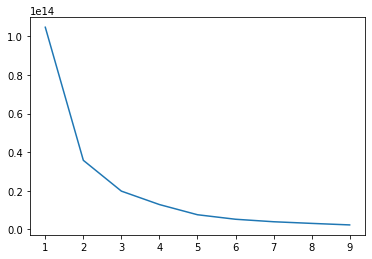

In [200]:
# Chequeo con la técnica del codo la cantidad óptima de clusters
n = range(1,10)
KMScore = []
for i in n:
    
    km = KMeans(n_clusters=i)
    km.fit(d)
    KMScore.append(km.inertia_)
import matplotlib.pyplot as plt
plt.plot(n,KMScore);

In [248]:
# Creo el cluster y lo agrego al dataset
km = KMeans(n_clusters=3)
km.fit(d)
dataset['PRESTAMOCluster'] = km.predict(d)
dataset = order_cluster('PRESTAMOCluster', 'PR_MONTO_ORIGINAL',dataset,True)

In [249]:
#creatinga new cluster dataframe
dataset_cluster = dataset.copy()
dataset_cluster = order_cluster('PRESTAMOCluster', 'PR_MONTO_ORIGINAL',dataset_cluster ,True)
#see details of the clusters
dataset_cluster.groupby('PRESTAMOCluster')['PR_MONTO_ORIGINAL'].describe()

,count,mean,std,min,25%,50%,75%,max
PRESTAMOCluster,,,,,,,,
0,33236.00,2755.54,8853.55,0.00,0.00,0.00,0.00,47000.00
1,4422.00,91552.78,34244.09,47200.00,61400.00,83000.00,115000.00,172500.00
2,961.00,253659.84,111993.79,173000.00,196000.00,226000.00,275800.00,1700000.00


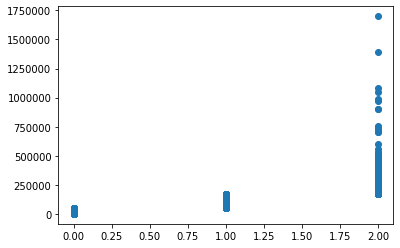

In [250]:
plt.plot(dataset_cluster['PRESTAMOCluster'], dataset_cluster['PR_MONTO_ORIGINAL'],'o')

##### Habiendo realizado los agrupamientos mencionados, intentaremos calcular una suerte de "score general" que sume los cluster ordenados de menor a mayor (es decir, partiendo de cluster "0" para los grupos de menor valor medio de la variable correspondiente), para representar el resultado de una agrupación "ad-hoc" por score general gráficamente, respecto de la valoración de los clientes en cada grupo. 

In [251]:
# Calculo Score General y utilizo mean() para ver detalles
dataset['ScoreGeneral'] = dataset['SALDOVISTACluster'] + dataset['CROSSELLCluster'] + dataset['PRESTAMOCluster'] 
dataset.groupby('ScoreGeneral')['DV_PROM_SALDO_12','CLI_INDICE_CROSS_SELL','PR_MONTO_ORIGINAL', 'VALOR_PROPIO_PROM_12'].mean()

,DV_PROM_SALDO_12,CLI_INDICE_CROSS_SELL,PR_MONTO_ORIGINAL,VALOR_PROPIO_PROM_12
ScoreGeneral,,,,
0,1457.35,1.00,178.05,23.75
1,4884.39,2.28,3870.25,135.17
2,12150.57,3.48,33232.58,391.58
3,13591.93,4.31,89770.04,601.22
4,25088.15,4.63,215170.29,1012.25
5,68480.96,4.90,312127.11,1006.84


In [255]:
# Agrupo los clientes en conjuntos de score general de 0 a 5, siendo 1 el grupo menos rentable y 4 el más rentable:
dataset['Segmento'] = 1
dataset.loc[dataset['ScoreGeneral']>=2,'Segmento'] = 2
dataset.loc[dataset['ScoreGeneral']>=3,'Segmento'] = 3
dataset.loc[dataset['ScoreGeneral']>=4,'Segmento'] = 4

In [256]:
dataset.groupby('Segmento')['VALOR_PROPIO_PROM_12'].mean()

Segmento
1     67.37
2    391.58
3    601.22
4   1012.01
Name: VALOR_PROPIO_PROM_12, dtype: float64

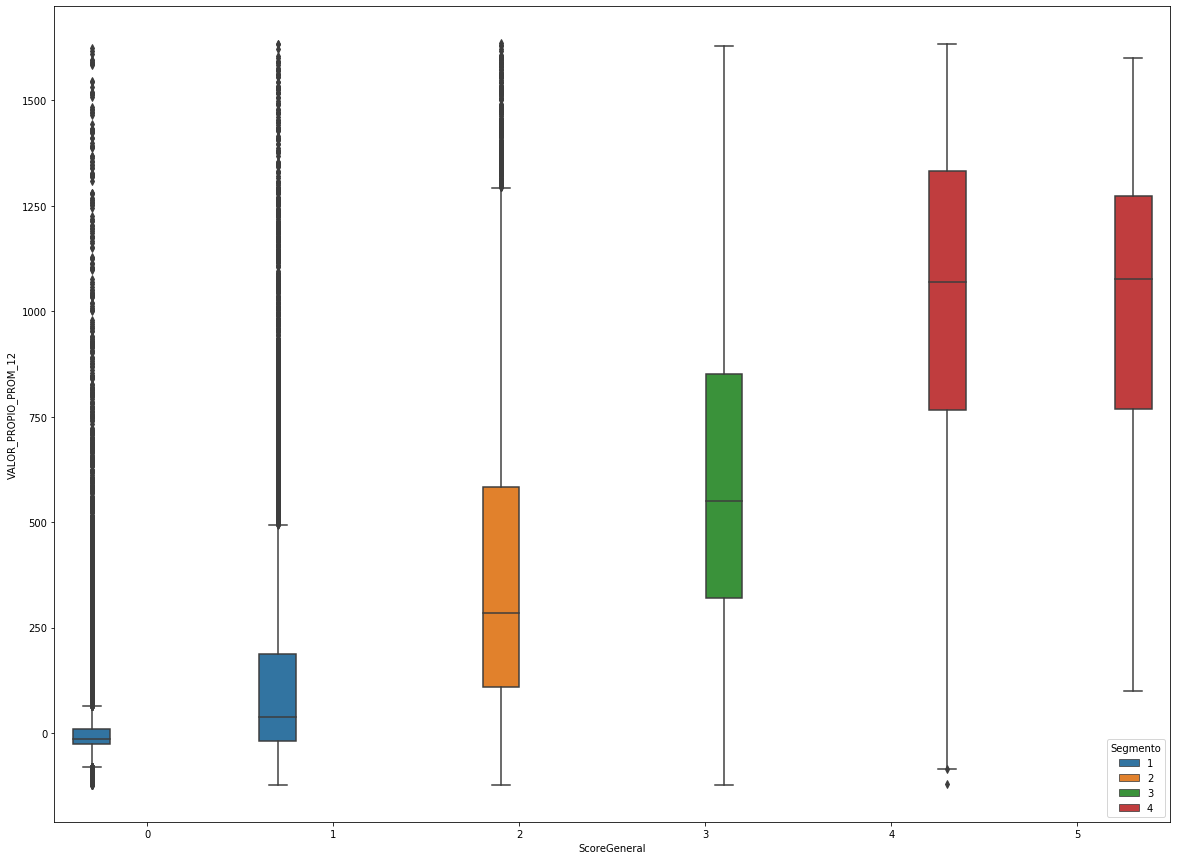

In [207]:
import seaborn as sns
plt.figure(figsize=(20, 15))

sns.boxplot(
    x = 'ScoreGeneral',
    y = 'VALOR_PROPIO_PROM_12',
    data = dataset,
    hue="Segmento"
)

##### La correlación positiva es bastante visible aquí. Los grupos de Segmento Score General mayor tienen mayor valor propio promedio.

##### Antes de construir el modelo de aprendizaje automático, necesitamos identificar cuál es el tipo de problema de predicción a resolver. LTV en sí es un problema de regresión. Un modelo de aprendizaje automático puede predecir el valor en $ del LTV del cliente. Pero aquí, identificamos segmentos de LTV. Porque hace que sea más práctico y fácil identificar estos segmentos para luego accionar sobre los mismos. Al aplicar la agrupación de K-means previamente, pudimos identificar nuestros grupos de LTV existentes y construir segmentos encima de ellos.
##### Teniendo en cuenta el negocio potencial subyacente dentro de cada grupo de clientes, debemos tratar a los clientes de manera diferente según su LTV estimado. En este caso, aplicamos la agrupación en clústeres y tendremos 4 segmentos (el número de segmentos siempre depende de la dinámica y los objetivos del negocio). En este caso, buscamos predecir para luego accionar diferentemente sobre 4 grupos de clientes: LTV Muy Bajo, Bajo, Medio y Alto.

## Desarrollo de Modelo de Predicción de Clusters de Valor del Cliente

In [254]:
# Convierto columnas categóricas a numéricas
dataset = pd.get_dummies(dataset)
# Calculo y muestro correlaciones
corr_matrix = dataset.corr()
corr_matrix['VALOR12Cluster'].sort_values(ascending=False)

VALOR12Cluster                                              1.00
VALOR_PROPIO_PROM_12                                        0.85
VALOR_PROPIO_PROM_6                                         0.71
ScoreGeneral                                                0.61
Segmento                                                    0.60
VALOR_PROPIO_PROM_3                                         0.55
CLI_INDICE_CROSS_SELL                                       0.50
PRESTAMOCluster                                             0.49
CROSSELLCluster                                             0.47
PR_MONTO_ORIGINAL                                           0.46
CLI_POSICION_ACTIVA                                         0.45
CLI_SALDO_DEUDA                                             0.45
FLAG_CC                                                     0.44
PR_MESES_CON_PRESTAMOS                                      0.42
PR_MESES_CON_PERSONALES                                     0.42
FLAG_PAQUETE_BI          

##### Vemos que los puntajes de valor propio, tenencias de productos y Score General serán útiles para nuestros modelos de aprendizaje automático.

In [99]:
# Creo X e y, X será el conjunto de features e y es la etiqueta Cluster LTV
X = dataset.drop(['VALOR12Cluster','VALOR_PROPIO_PROM_12', 'VALOR_PROPIO_PROM_3','VALOR_PROPIO_PROM_6', 'VALOR_PROPIO_PROM_3.1', 'VALOR_PROPIO_PROM_1','VALOR_PROPIO_PROM_1.1', 'CODIGO_CLIENTE'],axis=1)
y = dataset['VALOR12Cluster']

# Hago split en training y test sets
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import xgboost as xgb
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)

In [106]:
#XGBoost Multiclassification Model
ltv_xgb_model = xgb.XGBClassifier(max_depth=2, learning_rate=0.1,objective= 'multi:softprob',n_jobs=-1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))

y_pred = ltv_xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

Accuracy of XGB classifier on training set: 0.87
Accuracy of XGB classifier on test set: 0.87
              precision    recall  f1-score   support

           0       0.66      0.71      0.69       159
           1       0.93      0.95      0.94      1432
           2       0.68      0.59      0.63       340

    accuracy                           0.87      1931
   macro avg       0.76      0.75      0.75      1931
weighted avg       0.86      0.87      0.87      1931



##### La precisión y el recall son aceptables para el Cluster 0. Como ejemplo, para el grupo 0 (LTV muy bajo), si el modelo nos dice que este cliente pertenece al grupo 0, 90 de 100 serán correctos (precisión). Y el modelo identifica con éxito el 94% de los clientes reales del clúster 0 (recall). Realmente necesitamos mejorar el modelo para otros grupos. Por ejemplo, apenas detectamos el 52% de los clientes de Cluster 1 (LTV medio-bajo). Sin embargo, ya tenemos un modelo de aprendizaje automático que predice los segmentos de Valoración de nuestros clientes. Podemos adaptar fácilmente nuestras acciones en función de eso. Por ejemplo, no queremos perder clientes con un alto LTV.

##### Posibles acciones para mejorar la calidad del modelo:
##### 1 - Reducir la clasificación a 3 clusters
##### 2 - Probar otras combinaciones de split y train
##### 3 - Aplicar ajuste de hiperparámetros al modelo actual
##### 4 - Utilizar una técnica para mejorar la predicción de clases desbalanceadas
##### 5 - Probar algún modelo adicional a XGBoost

#### 1 - Realizamos una simulación con 3 clusters de  Valoración en lugar de 4 para entender si mejoran sustancialmente las métricas de Precision y Recall. 

In [101]:
# Realizo una prueba con 3 Clusters de  Valoración (Alto, Medio y  Bajo)
km = KMeans(n_clusters=3)
y=dataset['VALOR_PROPIO_PROM_12']
y=y.values.reshape(-1,1)
km.fit(y)
dataset['VALOR12Cluster3'] = km.predict(y)

In [102]:
# Creo un nuevo dataset para analizar cómo agrupó los valores el cluster
dataset_cluster = dataset.copy()
dataset_cluster = order_cluster('VALOR12Cluster3', 'VALOR_PROPIO_PROM_12',dataset_cluster ,True)
dataset_cluster.groupby('VALOR12Cluster3')['VALOR_PROPIO_PROM_12'].describe()

,count,mean,std,min,25%,50%,75%,max
VALOR12Cluster3,,,,,,,,
0,28691.00,14.33,75.46,-122.60,-26.96,-8.87,43.39,235.63
1,6773.00,456.07,155.88,235.84,322.97,428.82,577.99,791.15
2,3155.00,1124.36,234.87,791.93,916.75,1089.33,1304.43,1635.07


In [103]:
y2 = dataset['VALOR12Cluster3']

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size=0.05, random_state=56)

In [105]:
#XGBoost Multiclassification Model
ltv_xgb_model = xgb.XGBClassifier(max_depth=2, learning_rate=0.1,objective= 'multi:softprob',n_jobs=-1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))

y_pred = ltv_xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

Accuracy of XGB classifier on training set: 0.87
Accuracy of XGB classifier on test set: 0.87
              precision    recall  f1-score   support

           0       0.66      0.71      0.69       159
           1       0.93      0.95      0.94      1432
           2       0.68      0.59      0.63       340

    accuracy                           0.87      1931
   macro avg       0.76      0.75      0.75      1931
weighted avg       0.86      0.87      0.87      1931



##### Reducir a 3 clusters la predicción eleva de base el F1-score (Accuracy) de 0.81 a 0.87. Sin embargo, intentaremos mejorar el F1-score manteniendo la misma cantidad de clusters original.

##### 2 - Probamos otra combinación de train y test.

In [257]:
# Pruebo otras combinaciones de split y train
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import xgboost as xgb
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=56)

In [ ]:
#XGBoost Multiclassification Model
ltv_xgb_model = xgb.XGBClassifier(max_depth=2, learning_rate=0.1,objective= 'multi:softprob',n_jobs=-1).fit(X_train, y_train)

/Users/nicolashmartins/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [ ]:
# Calculo los indicadores provenientes de la matriz de confusión de cada clase
print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))

y_pred = ltv_xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
# Implemento una función de clasification report que me calcula el AUC para la predicción de cada clase.
import pandas as pd
import numpy as np
from scipy import interp

from  sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

def class_report(y_true, y_pred, y_score=None, average='micro'):
    if y_true.shape != y_pred.shape:
        print("Error! y_true %s is not the same shape as y_pred %s" % (
              y_true.shape,
              y_pred.shape)
        )
        return

    lb = LabelBinarizer()

    if len(y_true.shape) == 1:
        lb.fit(y_true)

    #Value counts of predictions
    labels, cnt = np.unique(
        y_pred,
        return_counts=True)
    n_classes = len(labels)
    pred_cnt = pd.Series(cnt, index=labels)

    metrics_summary = precision_recall_fscore_support(
            y_true=y_true,
            y_pred=y_pred,
            labels=labels)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index,
        columns=labels)

    support = class_report_df.loc['support']
    total = support.sum() 
    class_report_df['avg / total'] = avg[:-1] + [total]

    class_report_df = class_report_df.T
    class_report_df['pred'] = pred_cnt
    class_report_df['pred'].iloc[-1] = total

    if not (y_score is None):
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for label_it, label in enumerate(labels):
            fpr[label], tpr[label], _ = roc_curve(
                (y_true == label).astype(int), 
                y_score[:, label_it])

            roc_auc[label] = auc(fpr[label], tpr[label])

        if average == 'micro':
            if n_classes <= 2:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                    lb.transform(y_true).ravel(), 
                    y_score[:, 1].ravel())
            else:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                        lb.transform(y_true).ravel(), 
                        y_score.ravel())

            roc_auc["avg / total"] = auc(
                fpr["avg / total"], 
                tpr["avg / total"])

        elif average == 'macro':
            # First aggregate all false positive rates
            all_fpr = np.unique(np.concatenate([
                fpr[i] for i in labels]
            ))

            # Then interpolate all ROC curves at this points
            mean_tpr = np.zeros_like(all_fpr)
            for i in labels:
                mean_tpr += interp(all_fpr, fpr[i], tpr[i])

            # Finally average it and compute AUC
            mean_tpr /= n_classes

            fpr["macro"] = all_fpr
            tpr["macro"] = mean_tpr

            roc_auc["avg / total"] = auc(fpr["macro"], tpr["macro"])

        class_report_df['AUC'] = pd.Series(roc_auc)

    return class_report_df

In [ ]:
report_with_auc = class_report(
    y_true=y_test, 
    y_pred=ltv_xgb_model.predict(X_test), 
    y_score=ltv_xgb_model.predict_proba(X_test))

print(report_with_auc)

##### Modificar la proporción de train y set mejora levemente en F1-score de las clases más pequeñas (1 a 3)

#### 3 - Aplicamos ajuste de hiperparámetros al modelo actual

In [ ]:
from datetime import datetime
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [ ]:
# Implemento Random Search sobre XGBoost Multiclassification Model para encontrar hiperparámetros que mejoren el modelo
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
# En Google Colab se simuló con el dataset completo 
random_search = RandomizedSearchCV(ltv_xgb_model, param_distributions=param_grid, scoring='f1_macro', n_jobs=4, cv=5, verbose=3, random_state=1001 )
start_time = timer(None) # variable para calcular tiempo de inicio y fin
random_search.fit(X, y)
timer(start_time)

In [ ]:
random_search.best_params_

In [ ]:
random_search.best_estimator_

In [ ]:
# Entreno nuevamente el modelo con la optimización de hiperparámetros
from numpy import nan
ltv_xgb_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None).fit(X_train, y_train)

In [ ]:
# Calculo los indicadores de precisión de cada clase
print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))

y_pred = ltv_xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

In [33]:
report_with_auc = class_report(
    y_true=y_test, 
    y_pred=ltv_xgb_model.predict(X_test), 
    y_score=ltv_xgb_model.predict_proba(X_test))

print(report_with_auc)

NameError: name 'y_test' is not defined

##### Si bien, la aplicación de la optimización de hiperparámetros mejoró el precision y recall, intentaré mejorar el recall de los cluster más pequeños. Esto de debe a la existencia de clases (clusters) debalanceados. Es por eso que utilizaré una técnica para hacer oversampling sobre los datos desbalanceados.


#### 4 - Utilizamos una técnica para mejorar la predicción de clases desbalanceadas

In [ ]:
# Resumidamente, la distribución de las clases de los clusters es la siguiente:
dataset["VALOR12Cluster"].value_counts().plot.bar()

In [ ]:
#Importo librerías para oversamplear el dataset que se utilizan cuando tengo variables categóricas y continuas
from collections import Counter
from imblearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
# summarize class distribution
print(Counter(y))

In [ ]:
oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
X_over, y_over = oversample.fit_resample(X, y)
# summarize class distribution
print(Counter(y_over))

In [ ]:
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
# define pipeline
steps = [('over', RandomOverSampler()), ('model', ltv_xgb_model)]
ltv_xgb_modelover = Pipeline(steps=steps)

In [ ]:
ltv_xgb_modelover.fit(X_train, y_train)

In [ ]:
# Calculo los indicadores de precisión de cada clase
print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_modelover.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_modelover.score(X_test[X_train.columns], y_test)))

y_pred = ltv_xgb_modelover.predict(X_test)
print(classification_report(y_test, y_pred))

In [34]:
report_with_auc = class_report(
    y_true=y_test, 
    y_pred=ltv_xgb_modelover.predict(X_test), 
    y_score=ltv_xgb_modelover.predict_proba(X_test))

print(report_with_auc)

NameError: name 'y_test' is not defined

El balanceo de clases no logró un F1-score más balanceado para los 4 clusters de Valoración ni no mejoró el F1 global. Intentaremos una optimización de hiperparámetros que incluya pesos para las clases desde el XGBoost.

In [ ]:
# Implemento Random Search sobre XGBoost Multiclassification Model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'scale_pos_weight': [1, 10, 25, 50, 75, 100, 200, 300, 1000, 5000, 10000, 15000]
        }
random_search = RandomizedSearchCV(ltv_xgb_model, param_distributions=param_grid, scoring='f1_macro', n_jobs=4, cv=5, verbose=3, random_state=1001 )

start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X, y)
timer(start_time) # timing ends here for "start_time" variable

In [ ]:
random_search.best_params_

In [ ]:
random_search.best_estimator_

In [ ]:
# Entreno nuevamente el modelo con la optimización de hiperparámetros considerando los pesos de los clusters
ltv_xgb_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=100, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None).fit(X_train, y_train)

In [35]:
# Calculo los indicadores de precisión de cada clase
print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))

y_pred = ltv_xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

NameError: name 'ltv_xgb_model' is not defined

In [ ]:
report_with_auc = class_report(
    y_true=y_test, 
    y_pred=ltv_xgb_model.predict(X_test), 
    y_score=ltv_xgb_model.predict_proba(X_test))

print(report_with_auc)

#### Se logra un modelo hiperparámetros optimizados para clases desbalanceadas, con un grado de F1-Score razonable. Revisamos cuáles son las variables que más considera el modelo para predecir el valor de los clientes.

In [ ]:
from xgboost import plot_importance
plot_importance(ltv_xgb_model, max_num_features=20)
plt.show()

#### 5 - Aplicación de modelo predictivo alternativo

Vamos a intentar mejorar la predicción con un LightGBM

In [ ]:
import lightgbm as lightgbm
# Creo los LightGBM data containers
# categorical_features = [c for c, col in enumerate(data.columns) if 'cat' in col]
import re
X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
y_train = y_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test = X_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
y_test = y_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
train_data = lightgbm.Dataset(X_train, label= y_train)
test_data = lightgbm.Dataset(X_test, label=y_test)

# Entreno el modelo
parameters = {
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_class': 4,
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

lgbm = lightgbm.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=5000,
                       early_stopping_rounds=100)

In [ ]:
# Calculo los indicadores de precisión de cada clase
print(classification_report(y_test, y_pred, target_names=['0', '1', '2', '3']))

In [36]:
# Realizo la optimización de hiperparámetros para el modelo en cuestión
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

#Este parámetro define la cantidad de puntos de hiperparámetros a testear (suele probarse en 100 pero se bajó a 10 por performance local
n_HP_points_to_test = 10

clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='multi_logloss', objective='multi_class', n_jobs=4, n_estimators=500)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='f1_macro',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)


NameError: name 'lgb' is not defined

In [ ]:
start_time = timer(None) # comienza a contar el tiempo desde este punto
gs.fit(X_train, y_train)
timer(start_time) # termina de contar el tiempo aquí

In [ ]:
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

In [ ]:
opt_parameters = {'colsample_bytree': 0.9731668400523877, 'min_child_samples': 171, 'min_child_weight': 1e-05, 'num_leaves': 41, 'reg_alpha': 10, 'reg_lambda': 100, 'subsample': 0.5575732396028996}

In [ ]:
clf_sw = lgb.LGBMClassifier(**clf.get_params())

In [ ]:
# seteo parámetros óptimos
clf_sw.set_params(**opt_parameters)

In [ ]:
sklearn.metrics.SCORERS.keys()

In [ ]:
gs_sample_weight = GridSearchCV(estimator=clf_sw, 
                                param_grid={'scale_pos_weight':[1,10,50, 100, 500,1000]},
                                scoring='f1_macro',
                                cv=5,
                                refit=True,
                                verbose=True)

In [ ]:
#Pruebo si el hiperparámetro para clases de desbalanceadas arroja un valor distinto de 1 para ajustar el hiperparámnetro
gs_sample_weight.fit(X_train, y_train)
print('Best score reached: {} with params: {} '.format(gs_sample_weight.best_score_, gs_sample_weight.best_params_))

In [ ]:
#Alternativa no utilizada: configuro desde la optimización de HP
#clf_final = lgb.LGBMClassifier(**gs.best_estimator_.get_params())

#Configuro localmente desde valores hardcodeados
clf_final = lgb.LGBMClassifier(**clf.get_params())

#Seteo parámetros óptimos
clf_final.set_params(**opt_parameters)

#Entreno el modelo optimizado
clf_final.fit(X_train, y_train)

In [ ]:
# Realizo la predicción con el modelo óptimo entrenado
y_pred = clf_final.predict_proba(X_test)
y_pred = pd.DataFrame(y_pred).apply(lambda x: np.argmax(x), axis=1)

In [ ]:
# Calculo los indicadores de precisión de cada clase
print(classification_report(y_test, y_pred, target_names=['0', '1', '2', '3']))

#### Encuentro que el modelo LightGBM con hiperparámetros optimizados arroja los mejores resultados, alcanzando un accuracy de .82 y un f1 score weighted average de 0.82. Entiendo que es un modelo aceptable para clasificar clientes por grupos de Valoración.